**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

In [5]:
def read_in_an_image():
    # Modified this cell to a function since I am using a 
    # different function for reading and processing all images.
    # reading in an image
    sample_image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
    #printing out some stats and plotting
    print('This image is:', type(sample_image), 'with dimensions:', sample_image.shape)
    plt.imshow(sample_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def convert_rgb_2_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def select_colors_white_yellow(image):
    converted = convert_rgb_2_hls(image)
    
    # White mask
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255,255,255])
    white_mask = cv2.inRange(converted, lower, upper)
    
    # Yellow mask
    lower = np.uint8([10, 0, 100])
    upper = np.uint8([40,255,255])
    yellow_mask = cv2.inRange(converted, lower, upper)

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)


def average_slope_and_intercept(lines):
    # This function takes the individual line segments
    # and determines their slope and intercept.
    # line y = mx + b
    # m = slope, b = intercept
    # intercept b = y - mx
    # Finally, it returns the wighted average slope and intercept
    # for the left and right lane.
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if (0.4 < slope < 1.0) or (-1.0 < slope < -0.4):
                intercept = y1 - slope*x1
                #print("slope %f, intercept %f "%(slope, intercept))
                seg_length = np.sqrt((y2-y1)**2.0 + (x2 - x1)**2.0)
                if slope > 0:
                    left_lines.append((slope,intercept))
                    left_weights.append(seg_length)
                elif slope < 0:
                    right_lines.append((slope,intercept))
                    right_weights.append(seg_length)
            else:
                pass
            
    # Longer lines get more weighted.           
    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    
    return left_lane, right_lane



def determine_lane_coordinates(y1, y2, line):
    # This function takes the weighted avearage of the a lane (left and right)
    # and determines their exact location (x,y coordinates) in the image.
    
    slope, intercept = line
    # x = (y - b) / m
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1,y1), (x2,y2))

def get_complete_lanes_from_segments(image, lines):
    # This function takes the lane segments and determines
    # the complete lane coordinates which are needed to 
    # draw on the original image.
    
    left_lane, right_lane = average_slope_and_intercept(lines)
    #print(left_lane, right_lane)
    y1 = image.shape[0]
    y2 = y1*0.6 #The y coordinate where the line ends
    
    left_line = determine_lane_coordinates(y1, y2, left_lane)
    right_line = determine_lane_coordinates(y1, y2, right_lane)
    
    return left_line, right_line

def draw_unbroken_lanes(image, lines, color=[255,0,0], line_weight = 15):
    # This function draws extrapolated left and rigt lanes on a blank image
    only_lanes = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(only_lanes, *line, color, line_weight)
    return only_lanes

def hough_lines_continuous(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    complete_lines = get_complete_lanes_from_segments(img, lines)                    
    return draw_unbroken_lanes(line_img, complete_lines)

def display_two_images( image_1, image_2):
    fig = plt.figure(figsize=(15,17))
    a = fig.add_subplot(1,2,1)
    a.set_title("Original")
    plt.imshow(image_1)
    a = fig.add_subplot(1,2,2)
    a.set_title("Lane marked")
    plt.imshow(image_2)
    plt.show()
        
        

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
def list_test_images():
    # Modified this cell to function since I don't want
    # this cell to be executed.
    os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

solidwhitecurve.jpg


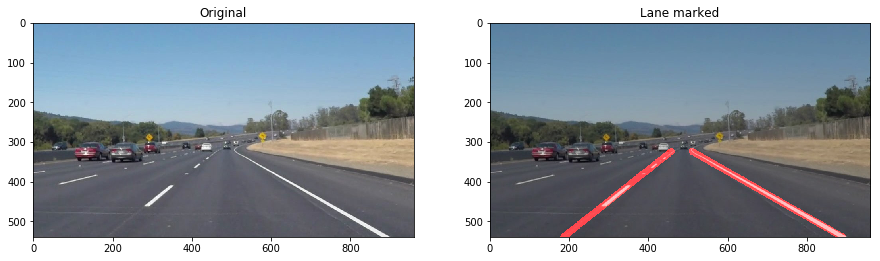

solidwhiteright.jpg


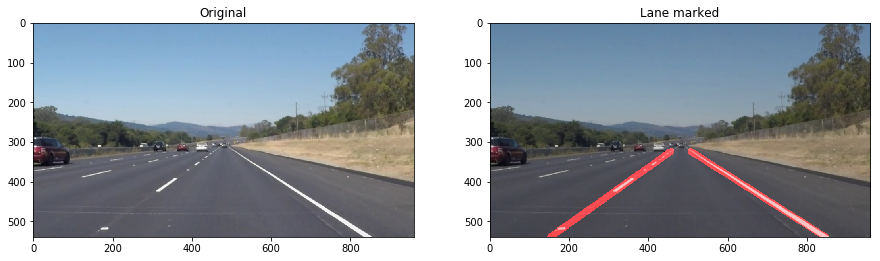

solidyellowcurve.jpg


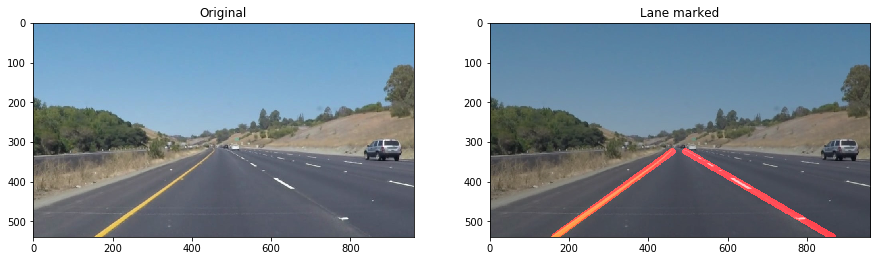

solidyellowcurve2.jpg


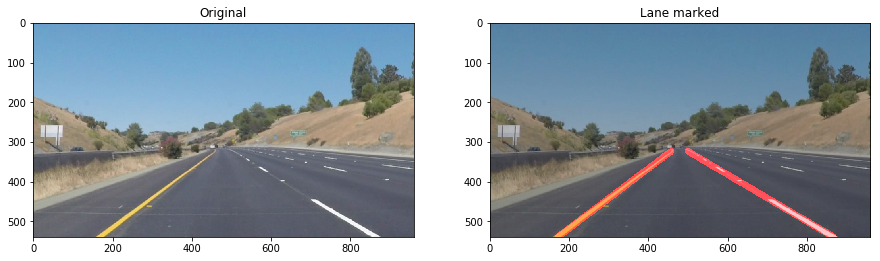

solidyellowleft.jpg


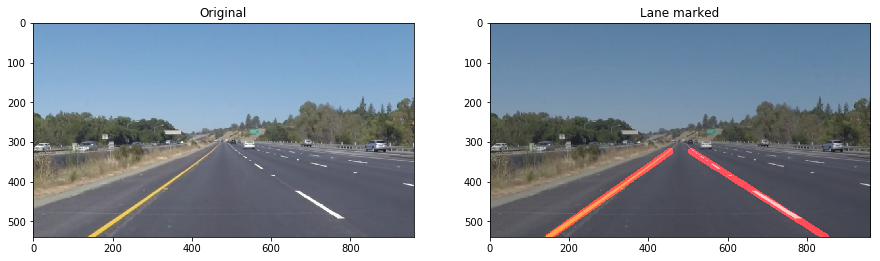

whitecarlaneswitch.jpg


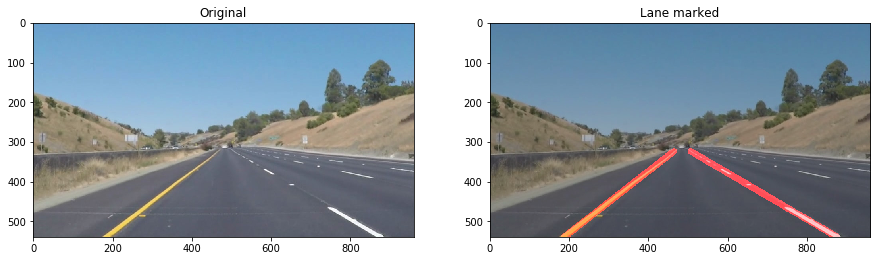

In [8]:
# Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def pipeline_process_image(image):
    
    # Select the White and Yellow colors
    color_selected_image = select_colors_white_yellow(image)
    #plt.imshow(color_selected_image)

    # Convert the image to gray scale so that Canny Edge Detection 
    # could be applied.
    gray_image = grayscale(color_selected_image)
    #plt.imshow(gray_image, cmap='gray')


    # Smoothen the edges with Gaussian Blur
    blur_image = gaussian_blur(gray_image, kernel_size=7)
    #plt.imshow(blur_image, cmap='gray')

    # Canny Edge Detection
    # Recommended ratio between low and high thresholds is 3.
    low_threshold = 50
    high_threshold = 150
    edge_detected_image = canny(blur_image, low_threshold, high_threshold)
    #plt.imshow(edge_detected_image, cmap='gray')


    # Identify the Region of Interest.
    left_bottom = [120,539]
    left_top = [400,320]
    right_bottom = [880,539]
    right_top = [600,320]
    roi_polygon = np.array([left_bottom, left_top, right_top, right_bottom], dtype=np.int32)
    roi_image = region_of_interest(edge_detected_image, [roi_polygon])
    #plt.imshow(roi_image, cmap='gray')

    #Parameters for Hough Lines
    rho = 1
    theta = np.pi/180
    threshold = 15
    min_line_len = 5 # There are some very small length segments in the images.
    max_line_gap = 20
    alpha = 0.8
    beta = 2.0
    lamda = 1
    segments = None
    if segments is not None:
        # This function returns a black image with segmented red lines. 
        line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
    else:
        # This function returns a black image with continuous red lines.
        line_image = hough_lines_continuous(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(line_image)
    
    # Merge the red lane lines on to teh original image
    final_image = weighted_img(line_image, image, alpha, beta, lamda)
    #plt.imshow(final_image)
    
    
    
    return final_image




def process_and_display_test_images():
    # This function 
    #    1. reads the test images from the test_images directory
    #    2. processes them
    #    3. displays the processed images
    #    4. writes the processed images to test_images directory
    for in_file in os.listdir("test_images/"):
        folder = "test_images"
        path = folder + "/" + in_file
        image = mpimg.imread(path)
        print(in_file.lower())
        out_image = pipeline_process_image(image)
        
        # Save a copy of the processed image
        out_file_name = folder + "/" + "Processed" + in_file
        cv2.imwrite(out_file_name, cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))
        
        # Display the orginal and lane marked final images.
        display_two_images( image, out_image)

# Process all the test images and display 
# the original and processed images.
process_and_display_test_images()        

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline_process_image(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos/ProcessedSolidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos/ProcessedSolidWhiteRight.mp4
[MoviePy] Writing video test_videos/ProcessedSolidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 60.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/ProcessedSolidWhiteRight.mp4 

Wall time: 4.04 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'test_videos/ProcessedSolidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos/ProcessedSolidYellowLeft.mp4
[MoviePy] Writing video test_videos/ProcessedSolidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:11<00:00, 59.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/ProcessedSolidYellowLeft.mp4 

Wall time: 11.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos/ProcessedChallenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos/ProcessedChallenge.mp4
[MoviePy] Writing video test_videos/ProcessedChallenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 31.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/ProcessedChallenge.mp4 

Wall time: 8.88 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))








# **Finding Lane Lines on the Road** 


## Writeup



---


**Finding Lane Lines on the Road**


The goals / steps of this project are the following:

* Make a pipeline that finds lane lines on the road

* Reflect on your work in a written report




---


## Reflection



###  1. Pipeline Description

#### Pipeline Summary
My pipeline consists of the following steps:

* Color Selection 
* Canny Edge Detection
* Region of Interest Selection
* Hough Lines Detection

The pipeline_process_image() function implements the pipeline and
calls multiple provided helper functions and new functions I have added.

#### Overall Strategy
To start with, I completely focussed on one image that had a solid white line on the right and segmented white lines on the
left. I executed the pipeline step by step. For each step, I displayed the image and made sure that step works as expected.
Once the pipeline produced the correct result, I started working on another image that had both yellow and white lines. 
After detecting the yellow lines correctly, I tested all the test images in the test_images directory. 
Once the test images are verified, I focussed on the videos.


#### Pipeline Details 

##### Color Selection
Intially, I wrote a function using the RGB color space as was done in the classroom example.
But this function didn't detect the yellow lines. Realized that the HLS color space provided 
better color selection thresholds. I converted the image to HLS and used HLS thresholds to
detect white and yellow lines.
This is captured in the select_colors_white_yellow()
![alt text](test_images\colorselected.jpg)



##### Canny Edge Detection
This consists of multiple sub-steps

* Converted the image to gray scale.
![alt text](test_images\grayscale.jpg)


* Applied Gaussian Blur to smooth out the edges.
![alt text](test_images\gaussianBlur.jpg)


* Used the helper function canny() to detect the edges.
  As recommended in the lesson, kept the ratio between low and high thresholds to 3.
![alt text](test_images\canny.jpg)



##### Region of Interest
This step needed some experimentation to exactly define the needed area of interest Polygon.
![alt text](test_images\roi.jpg)



##### Hough Lines Detection
A lot of experimentation went in to defining the values for the parameters.
Especially notable is the min_line_len, which I kept it as 5 since I wanted to detect
even the smallest white segment in the image. 

Instead of modifying the provided helper function draw_lines(), I created a new function
called draw_unbroken_lines() and called it from a new function hough_lines_continuous().
The reason for this is that I wanted to keep the original helper functions intact so that
I can go back to them if needed.

The hough_lines_continuous() function called a new function called get_complete_lanes_from_segments()
which took the individual segments, calculated their slope and intercept and returned the coordinates of
the extrapolated lines.
Finally, the new function draw_unbroken_lines() drew the extrapolated lines on a blank image.
![alt text](test_images\houghLines.jpg)


In the main function, the hough lines returned by the pipeline_process_image()
was added to the original image using the weighted_img() function.
![alt text](test_images\finalImage.jpg)



### 2. Potential Shortcomings 
This is a very simple lane detection program and I believe this pipeline 
won't work under the following scenarios:

* The road does not have a white or yellow lane at the edge of the road (rural areas)

* There is a sharp turn in the road.

* The road dips down sharply or goes up at  steep angle 

* During night, under yellow color sodium/mercury lights, the lane colors will not be yellow and white.

* There is a 2 line (no zebra markings) diagonal cross walk at an intersection. 

* There is a black bus ahead and it has 2 white lines painted coinciding with the white lanes on the road!



### 3. Possible Improvements. 

* To address many of the shortcomings, I believe the Region of Interest needs to be more flexible and not fixed.

* To improve night time lane detection, more colors must be detected.

* Steep lanes or sharp dips require different slope calculations.



### **Meeting the Rubric Requirements**

* The pipeline takes images from a video stream and creates an annotated video stream as output.

* The pipeline used the helper functions as well as newly added functions, identifies white and yellow continuous and segmented lanes
  and annotates the video stream with continuous left and right lanes. 


    
## **Final Thoughts**
It is just one week since the course started and I feel I have already learned a lot about Self Driving cars. 
I am very much impressed with the quality of the lessons. The quizzes and the project have been very cleverly 
designed so that students end up exploring and in the process learn the concepts well. 
Can't wait to go through the rest of the course.